In [1]:
import tensorflow as tf

!nvidia-smi  
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tue Feb 18 06:28:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# !pip install visualkeras

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
from matplotlib.image import imread
import cv2
import os

In [7]:
labels = pd.read_csv("/kaggle/input/inbreast/Training_set.csv")
labels.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [8]:
file_paths = [[fname, 'train/' + fname] for fname in labels['filename']]

In [9]:
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  5724 matches the number of filenames i.e.  5724


In [10]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,train/Image_1.jpg
1,Image_2.jpg,train/Image_2.jpg
2,Image_3.jpg,train/Image_3.jpg
3,Image_4.jpg,train/Image_4.jpg
4,Image_5.jpg,train/Image_5.jpg


In [11]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,train/Image_1.jpg,Density3Benign
1,Image_2.jpg,train/Image_2.jpg,Density1Benign
2,Image_3.jpg,train/Image_3.jpg,Density1Malignant
3,Image_4.jpg,train/Image_4.jpg,Density1Benign
4,Image_5.jpg,train/Image_5.jpg,Density1Malignant


# EDA

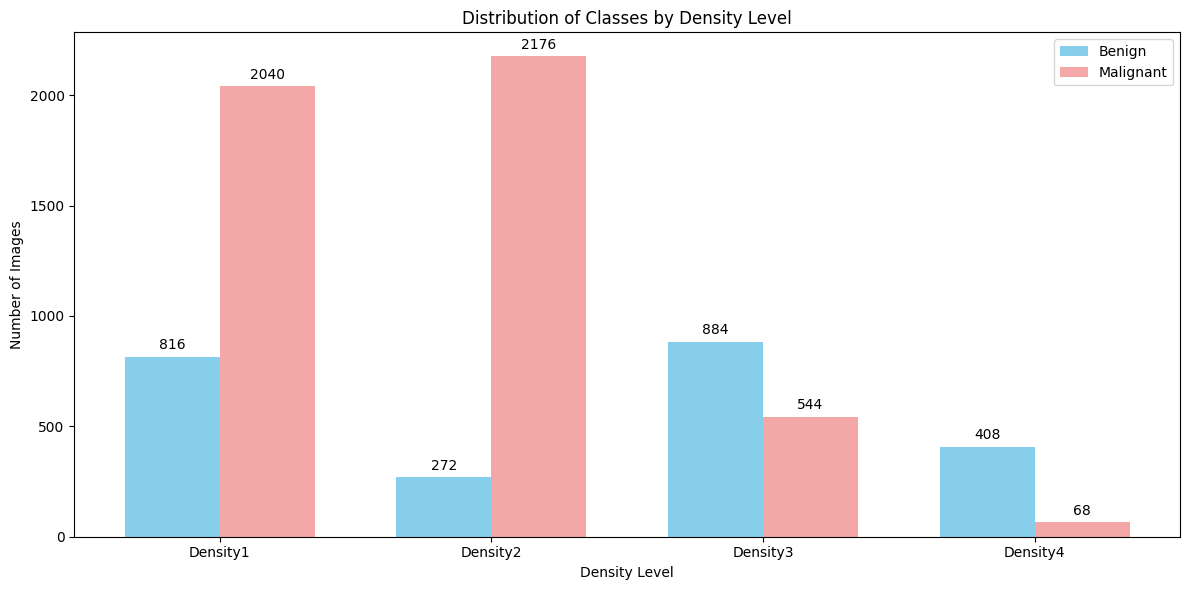

In [13]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Density1', 'Density2', 'Density3', 'Density4']
benign = [816, 272, 884, 408]
malignant = [2040, 2176, 544, 68]

x = np.arange(len(categories))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, benign, width, label='Benign', color='#87CEEB')  # Light blue
rects2 = ax.bar(x + width/2, malignant, width, label='Malignant', color='#F4A7A7')  # Light red

ax.set_ylabel('Number of Images')
ax.set_xlabel('Density Level')
ax.set_title('Distribution of Classes by Density Level')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Adjust layout
plt.tight_layout()

plt.show()

In [14]:
base_path = '/kaggle/input/inbreast'
train_data['filepaths'] = train_data['filepaths'].apply(lambda x: os.path.join(base_path, 'mamog', 'train', os.path.basename(x)))

print("New path:", train_data['filepaths'][0])
print("File exists:", os.path.exists(train_data['filepaths'][0]))

New path: /kaggle/input/inbreast/mamog/train/Image_1.jpg
File exists: True


In [15]:
first_image = train_data['filepaths'][0]

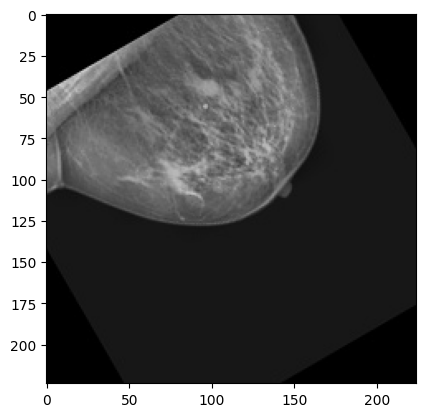

In [16]:
plt.imshow(imread(first_image))

In [17]:
dim1 = []
dim2 = []

for i in range(len(train_data)):
    img = imread(train_data['filepaths'][i])
    d1,d2,color = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


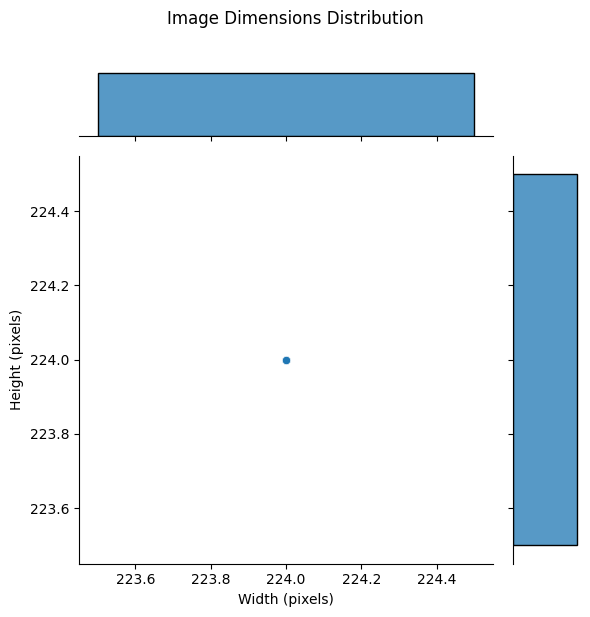

In [18]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'Height': dim1,
    'Width': dim2
})

g = sns.jointplot(
    data=df,
    x='Width',
    y='Height',
    kind='scatter'
)

# Add labels and title
g.fig.suptitle('Image Dimensions Distribution', y=1.02)
g.ax_joint.set_xlabel('Width (pixels)')
g.ax_joint.set_ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

In [19]:
data = []
image_size = 224
for i in range(len(train_data)):

    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, (image_size, image_size))
    if train_data['label'][i] == 'Density1Benign':
        data.append([new_img_array, 0])
    elif train_data['label'][i] == 'Density1Malignant':
        data.append([new_img_array, 1])
    elif train_data['label'][i] == 'Density2Benign':
        data.append([new_img_array, 2])
    elif train_data['label'][i] == 'Density2Malignant':
        data.append([new_img_array, 3])
    elif train_data['label'][i] == 'Density3Benign':
        data.append([new_img_array, 4])
    elif train_data['label'][i] == 'Density3Malignant':
        data.append([new_img_array, 5])
    elif train_data['label'][i] == 'Density4Benign':
        data.append([new_img_array, 6])
    elif train_data['label'][i] == 'Density4Malignant':
        data.append([new_img_array, 7])

In [20]:
data[0]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 4]

In [21]:
np.random.shuffle(data)

In [22]:
x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

x = np.array(x)
y = np.array(y)

In [23]:
x = x.reshape(x.shape[0], 224, 224, 1)

In [24]:
x.shape

(5724, 224, 224, 1)

In [26]:
image_shape = (224, 224, 1)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.20, random_state = 42)

In [28]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=image_shape, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  


model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  

model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-4),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,483,336 (196.39 MB)

 Trainable params: 51,482,568 (196.39 MB)

 Non-trainable params: 768 (3.00 KB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


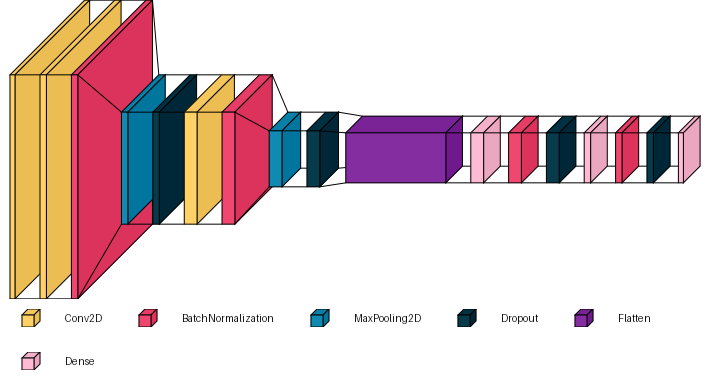

In [30]:
import visualkeras
from tensorflow.keras.utils import plot_model

# First, let's create a text-based visualization
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Then create a more detailed layered visualization using visualkeras
visualkeras.layered_view(model,
                        to_file='model_layered_view.png',
                        legend=True,
                        draw_volume=True,
                        spacing=25,
                        scale_z=0.1,    
                        scale_xy=1,
                        min_z=5,       
                        min_xy=50,
                        max_z=100,      
                        color_map={
                            'Conv2D': '#FFA07A', 
                            'MaxPooling2D': '#98FB98', 
                            'BatchNormalization': '#87CEFA', 
                            'Dropout': '#DDA0DD',  
                            'Dense': '#F0E68C',  
                            'Flatten': '#FFB6C1'  
                        })

In [31]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Рассчитываем веса классов
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Создаем словарь весов
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.1245088408644401, 1: 0.4423299845440495, 2: 3.308526011560694, 3: 0.4059397163120567, 4: 1.0444799270072993, 5: 1.6494956772334295, 6: 2.244607843137255, 7: 13.311046511627907}


In [33]:
%%time
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Увеличил batch size
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,  # Увеличил patience
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.2,
            patience=7,  # Увеличил patience
            min_lr=1e-6  # Добавил минимальный learning rate
        )
    ]
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9814 - loss: 0.0483 - val_accuracy: 0.8541 - val_loss: 0.6486 - learning_rate: 2.0000e-05
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9901 - loss: 0.0384 - val_accuracy: 0.8402 - val_loss: 0.6995 - learning_rate: 2.0000e-05
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9889 - loss: 0.0429 - val_accuracy: 0.8419 - val_loss: 0.7057 - learning_rate: 2.0000e-05
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9892 - loss: 0.0339 - val_accuracy: 0.8410 - val_loss: 0.7103 - learning_rate: 2.0000e-05
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9925 - loss: 0.0305 - val_accuracy: 0.8437 - val_loss: 0.7110 - learning_rate: 2.0000e-05
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9886 - loss: 0.0383 - val_accuracy: 0.8419 - val_loss: 0.7134 - learning_rate: 2.0000e-05
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/ste

In [56]:
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [57]:
# model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_val, y_val), callbacks = [early_stop])

In [34]:
metrics = pd.DataFrame(model.history.history)

<Axes: >

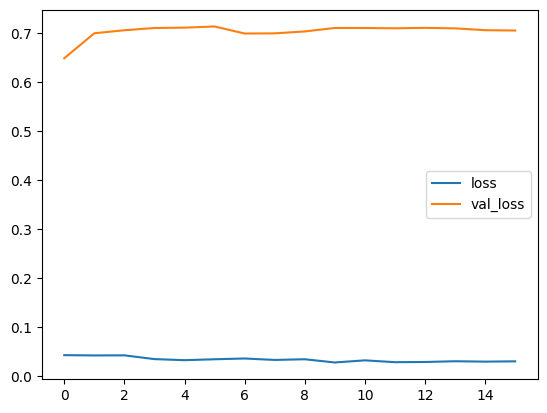

In [35]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

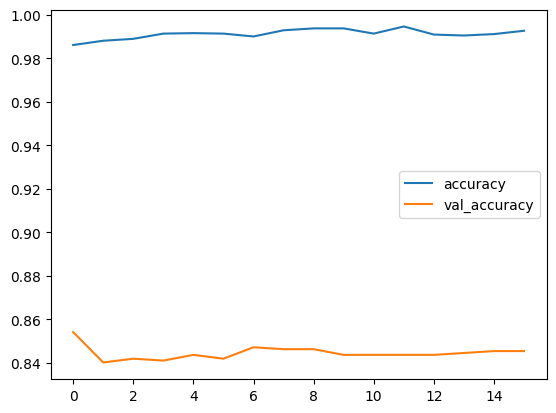

In [36]:
metrics[['accuracy', 'val_accuracy']].plot()

In [37]:
model.evaluate(X_val, y_val)

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8580 - loss: 0.6555


[0.6485537886619568, 0.8541484475135803]

In [43]:
# Получаем предсказания модели
y_pred = model.predict(X_val)

# Конвертируем в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)

# Если y_val в one-hot формате, конвертируем в метки классов
if len(y_val.shape) > 1:  # проверяем, является ли y_val one-hot encoded
    y_true_classes = np.argmax(y_val, axis=1)
else:
    y_true_classes = y_val

# Расчет F1-score
from sklearn.metrics import f1_score, classification_report

# Для каждого типа усреднения
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Macro F1-score: {f1_macro:.3f}")
print(f"Weighted F1-score: {f1_weighted:.3f}")

# Детальный отчет по всем классам
class_names = ['Density1Benign', 'Density1Malignant', 
               'Density2Benign', 'Density2Malignant',
               'Density3Benign', 'Density3Malignant',
               'Density4Benign', 'Density4Malignant']

print("\nDetailed classification report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Macro F1-score: 0.862
Weighted F1-score: 0.855

Detailed classification report:
                   precision    recall  f1-score   support

   Density1Benign       0.80      0.83      0.81       139
Density1Malignant       0.82      0.88      0.85       326
   Density2Benign       0.82      0.93      0.87        43
Density2Malignant       0.94      0.82      0.87       318
   Density3Benign       0.91      0.87      0.89       154
Density3Malignant       0.94      0.78      0.85        85
   Density4Benign       0.68      0.96      0.80        69
Density4Malignant       0.92      1.00      0.96        11

         accuracy                           0.85      1145
        macro avg       0.85      0.88      0.86      1145
     weighted avg       0.86      0.85      0.86      1145



In [38]:
from tensorflow.keras.models import load_model, save_model

In [39]:
classes = {0 : 'Density1Benign' ,
1 : 'Density1Malignant',
2: 'Density2Benign',
3 : 'Density2Malignant',
4 : 'Density3Benign',
5 : 'Density3Malignant',
6 : 'Density4Benign',
7 : 'Density4Malignant'}

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


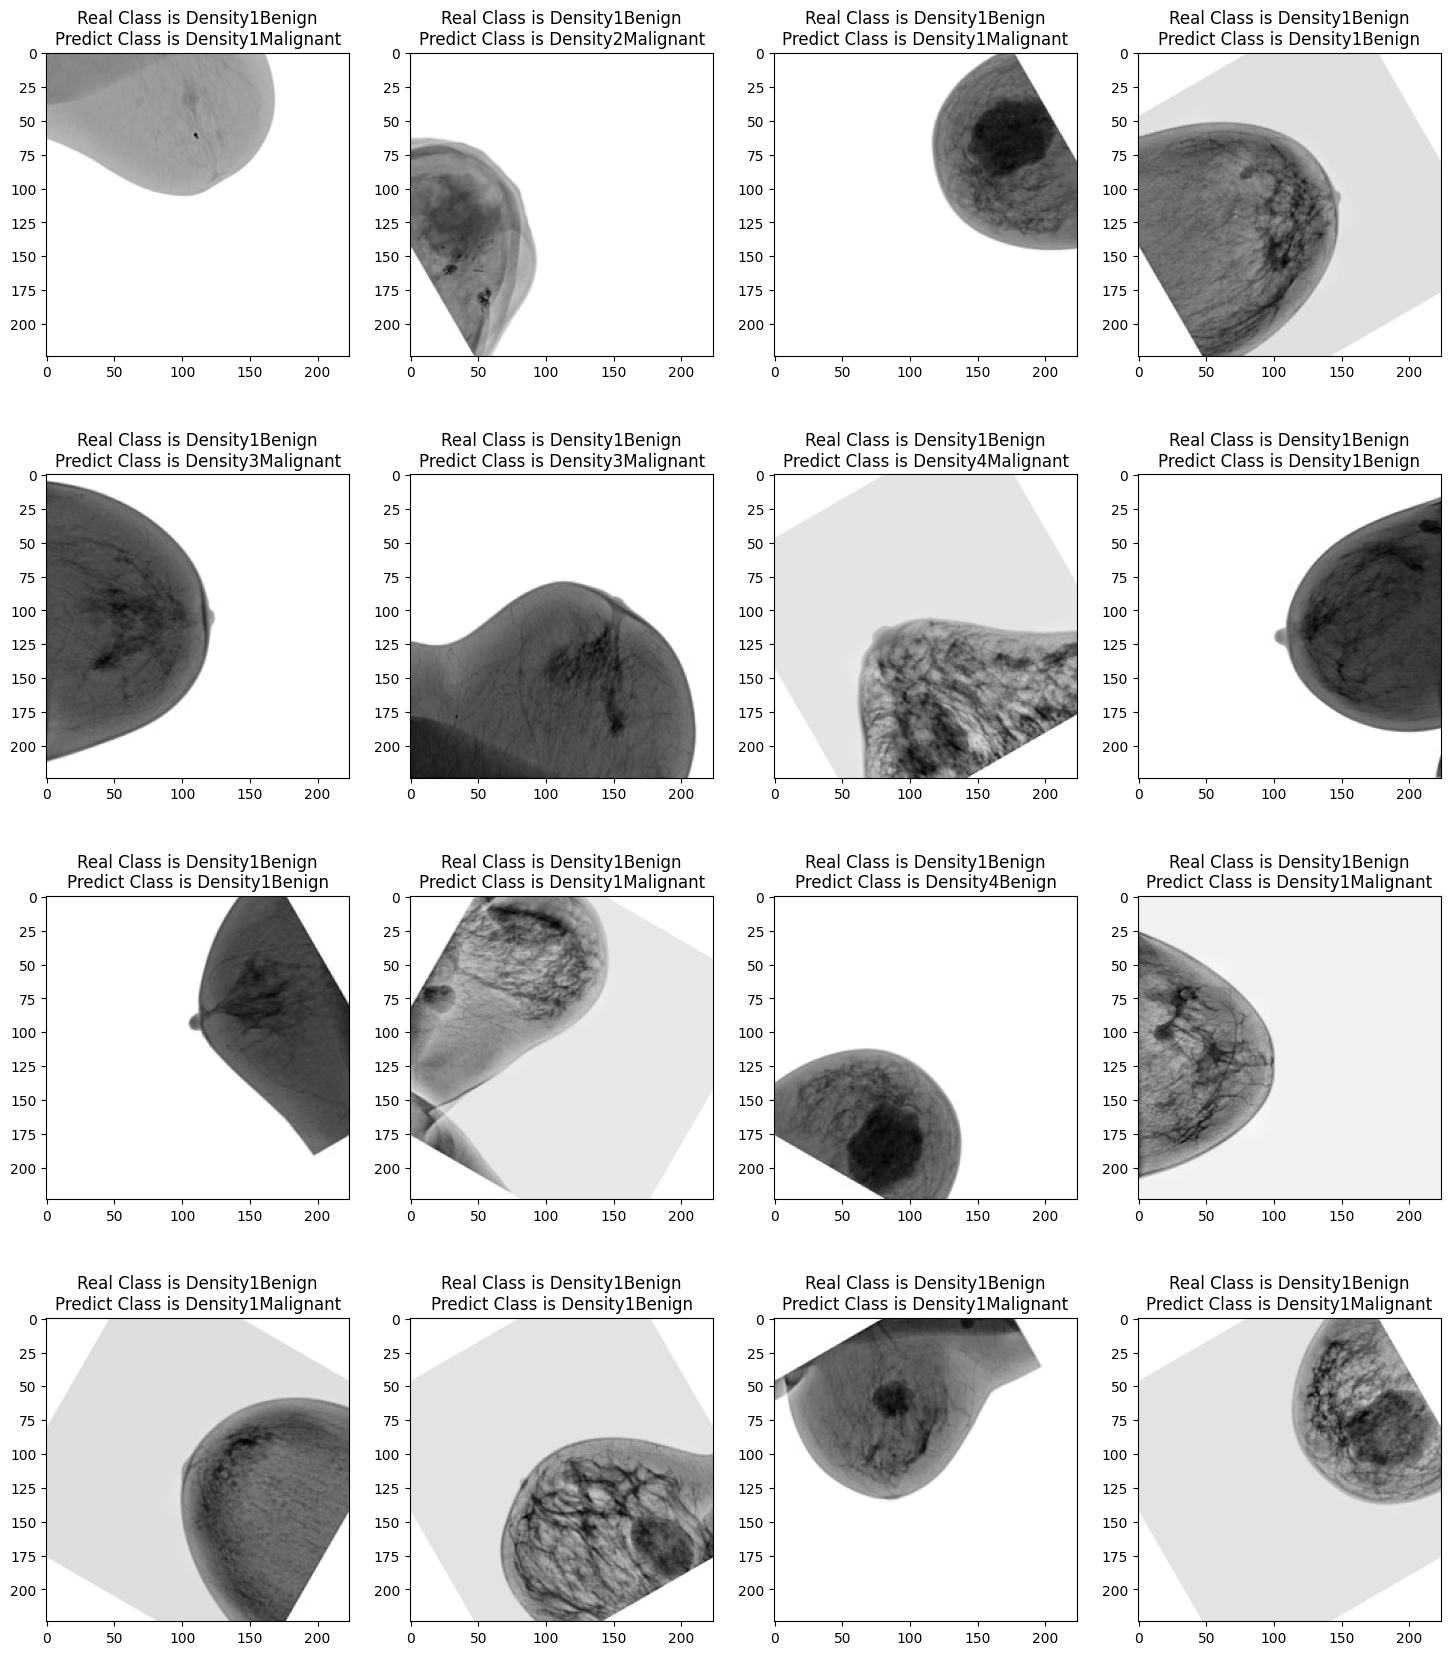

In [40]:
y_pred = model.predict(X_val)
X_test__ = X_val.reshape(X_val.shape[0], 224, 224)

fig, axis = plt.subplots(4, 4, figsize=(18, 21))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Class is {classes[y_val[i].argmax()]}\nPredict Class is {classes[y_pred[i].argmax()]}");

In [66]:
print("y_val shape:", y_val.shape)
print("y_pred shape:", y_pred.shape)
print("\nUnique values in y_val:", np.unique(y_val))
print("Unique values in y_pred:", np.unique(y_pred))

# Check the data types
print("\ny_val dtype:", y_val.dtype)
print("y_pred dtype:", y_pred.dtype)

# Check if either is continuous
print("\nIs y_val continuous?", np.any(y_val % 1 != 0))
print("Is y_pred continuous?", np.any(y_pred % 1 != 0))

# Print a few examples
print("\nFirst few y_val samples:", y_val[:5])
print("First few y_pred samples:", y_pred[:5])

y_val shape: (1145,)
y_pred shape: (1145, 8)

Unique values in y_val: [0 1 2 3 4 5 6 7]
Unique values in y_pred: [2.7367641e-11 1.3922234e-10 1.4422182e-10 ... 9.9992228e-01 9.9997687e-01
 9.9999928e-01]

y_val dtype: int64
y_pred dtype: float32

Is y_val continuous? False
Is y_pred continuous? True

First few y_val samples: [1 6 0 3 3]
First few y_pred samples: [[5.38505279e-02 5.37028372e-01 1.47192795e-02 3.35593611e-01
  1.54397013e-02 3.91672552e-03 2.10205689e-02 1.84311718e-02]
 [6.01730600e-04 9.97260690e-01 2.33708226e-04 4.39625932e-04
  4.85950935e-04 1.74348650e-04 7.53964414e-04 4.99282905e-05]
 [9.19312984e-02 8.66235018e-01 1.05718535e-03 1.26116043e-02
  1.06637217e-02 1.42025892e-02 2.37083249e-03 9.27694491e-04]
 [9.04751942e-04 3.15736892e-04 1.91178848e-03 9.70677078e-01
  1.46368816e-02 9.28604743e-04 9.16233053e-04 9.70885437e-03]
 [8.43208730e-01 1.08112141e-01 5.40265255e-03 1.75668467e-02
  3.99680436e-03 1.63829664e-03 8.75434652e-03 1.13202352e-02]]


In [67]:
import numpy as np

# Convert probability predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now create confusion matrix with the class labels
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes))

Confusion Matrix:
[[108   8   0   6   1   0   0   0]
 [  2 260   1  19  13   2  19   0]
 [  1   1  38   3   4   0   0   0]
 [ 12  17   0 283   7   0   7   1]
 [  0   0   1   9 139   1   5   0]
 [  2   3   0   5   1  82   1   0]
 [  1   4   0   0   0   0  62   0]
 [  0   0   0   3   0   0   0  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       123
           1       0.89      0.82      0.85       316
           2       0.95      0.81      0.87        47
           3       0.86      0.87      0.86       327
           4       0.84      0.90      0.87       155
           5       0.96      0.87      0.92        94
           6       0.66      0.93      0.77        67
           7       0.93      0.81      0.87        16

    accuracy                           0.86      1145
   macro avg       0.87      0.86      0.86      1145
weighted avg       0.87      0.86      0.86      1145



In [ ]:
# 